# Exercise: Introduction to Data Science

## Exercise 1: Understand and analyze the data

Import Libraries

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

%matplotlib inline

Get the gas station information history:
- STID: unique gas station id
- E5: price for one litre Super E5 (in tenth of a cent)
- E10: price for one litre Super E10 (in tenth of a cent)
- DIESEL: price for one litre Super Diesel (in tenth of a cent)
- DATECHANGE: date of this change
- CHANGED: bit mask for the change

In [127]:
price_data = pd.read_csv('example_sprit_cut_prices.csv', sep=';')
price_data.head()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
0,01bf5a06-4248-43a5-9524-56123fa3ab2f,1589,1549,1389,2014-10-02 05:22:01.000000,21
1,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1369,2014-10-02 05:26:01.000000,21
2,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1359,2014-10-02 09:06:01.000000,1
3,01bf5a06-4248-43a5-9524-56123fa3ab2f,1539,1499,1339,2014-10-03 12:14:01.000000,21
4,01bf5a06-4248-43a5-9524-56123fa3ab2f,1529,1489,1329,2014-10-03 14:14:01.000000,21


In [128]:
price_data.tail()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
2189521,f5552423-47e5-4290-bce2-5625bb6c8a69,1329,1309,1169,2015-02-14 13:46:01.000000,21
2189522,f5552423-47e5-4290-bce2-5625bb6c8a69,1429,1409,1259,2015-02-16 05:06:01.000000,21
2189523,f5552423-47e5-4290-bce2-5625bb6c8a69,1389,1369,1219,2015-02-16 07:22:01.000000,21
2189524,f5552423-47e5-4290-bce2-5625bb6c8a69,1369,1349,1239,2015-02-17 07:10:01.000000,21
2189525,f5552423-47e5-4290-bce2-5625bb6c8a69,1369,1349,1219,2015-02-17 08:02:01.000000,1


In [129]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189526 entries, 0 to 2189525
Data columns (total 6 columns):
STID            object
E5              int64
E10             int64
DIESEL          int64
DATE_CHANGED    object
CHANGED         int64
dtypes: int64(4), object(2)
memory usage: 100.2+ MB


It seems that no values are missing.

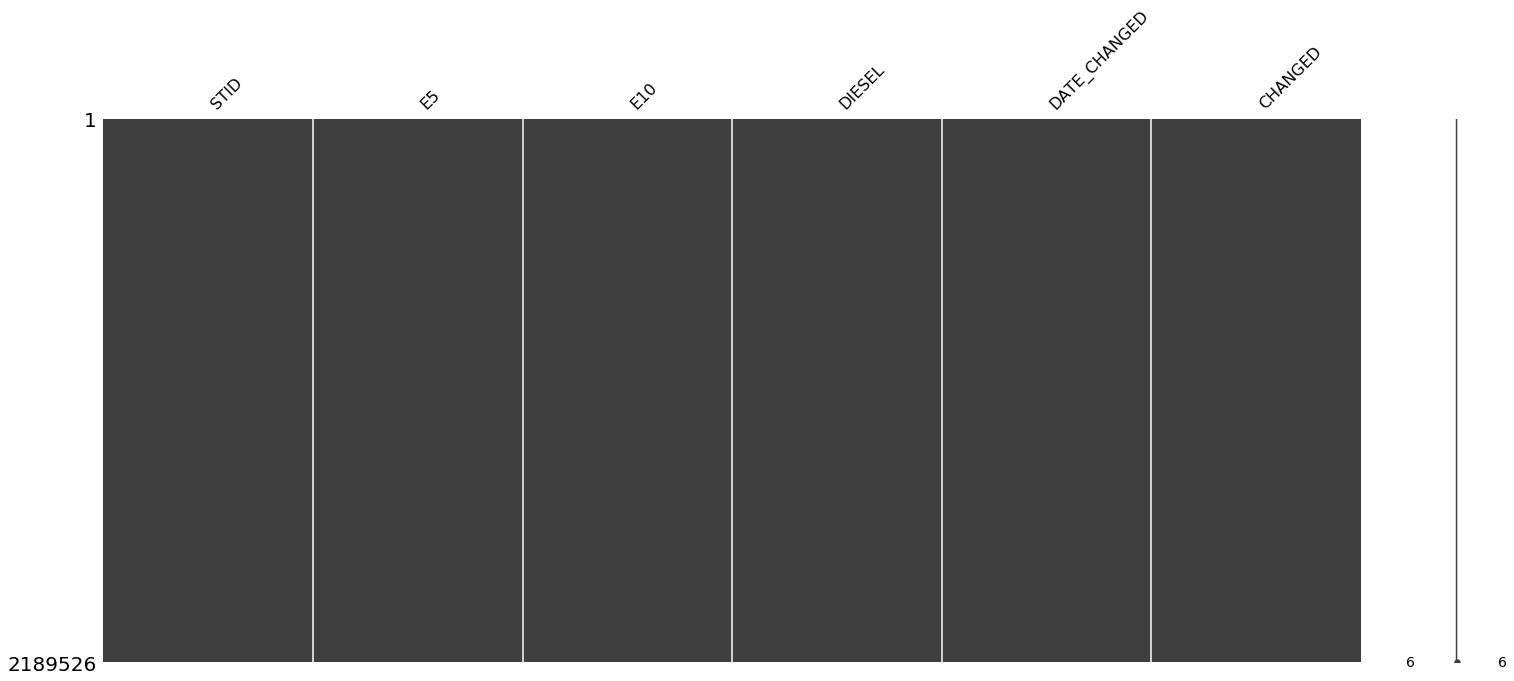

In [130]:
ms.matrix(price_data)

In [131]:
price_data.isnull().values.any()

False

In the history table are only price changes stored . The price at a certain time must therefore be calculated from the last change.
The minimum value for the different types of petrol is -1, which represents an invalid value.

In [132]:
price_data.describe()

,E5,E10,DIESEL,CHANGED
count,2.189526e+06,2.189526e+06,2.189526e+06,2.189526e+06
mean,1.434320e+03,1.404088e+03,1.247491e+03,1.871165e+01
std,2.091502e+02,2.116844e+02,1.037774e+02,8.031150e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
25%,1.379000e+03,1.349000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.429000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.324000e+03,2.100000e+01
max,9.999000e+03,9.999000e+03,1.129000e+04,6.300000e+01


First we remove duplicate rows

In [133]:
price_data.drop_duplicates(inplace=True)
price_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1094763 entries, 0 to 2177846
Data columns (total 6 columns):
STID            1094763 non-null object
E5              1094763 non-null int64
E10             1094763 non-null int64
DIESEL          1094763 non-null int64
DATE_CHANGED    1094763 non-null object
CHANGED         1094763 non-null int64
dtypes: int64(4), object(2)
memory usage: 58.5+ MB


Create a function for the price calculation:

Use the bitmask for changes:

|    Bitmask     | Diesel | E5 | E10 |
|---------|--------|----|-----|
| new     | 3      | 12 | 48  |
| removed | 2      | 8  | 32  |
| changed | 1      | 4  | 16  |

In [134]:
# before using this function sort the dataframe by STID and DATE_CHANGED and add a new column with STID values shifted by 1

def calculate_price(df, gasoline_type='diesel'):
    
    # create bitmask for the gasoline_type
    no_change = 0
    if gasoline_type is 'diesel':
        mask = 3
        new = 3
        removed = 2
        changed = 1
        name = 'DIESEL'
    elif gasoline_type is 'e5':
        mask = 12
        new = 12 
        removed = 8
        changed = 4
        name = 'E5'
    elif gasoline_type is 'e10':
        mask = 48
        new = 48
        removed = 32
        changed = 16
        name = 'E10'
    else:
        raise('Unknown gasoline type')
    
    # the first value of a gas station must be new or changed to ensure that the value is valid
    if df['STID'] != df['STID_SHIFT']:
        if int(df['CHANGED']) & mask == no_change and int(df['CHANGED']) & mask == removed:
            return -1
        else:
            return df[name]
        
    # all other values of the gas station
    else:
        # removed: value is invalid
        if int(df['CHANGED']) & mask == removed:
            return -1
        # no_change: value must be determinded from the previous value later
        elif int(df['CHANGED']) & mask == no_change:
            return np.nan
        # new or changed: value is valid
        else:
            return df[name]

Sort the dataframe by STID and DATE_CHANGED and add a new column with STID values shifted by 1

In [135]:
price_data = price_data.sort_values(['STID', 'DATE_CHANGED'])

price_data['STID_SHIFT'] = price_data['STID'].shift()

Calculate the prices.
The function fillna is used to determine the values with no changes from previous values

In [136]:
price_data['DIESEL'] = price_data.apply(calculate_price, gasoline_type='diesel', axis=1).fillna(method='ffill')

price_data['E5'] = price_data.apply(calculate_price, gasoline_type='e5', axis=1).fillna(method='ffill')

price_data['E10'] = price_data.apply(calculate_price, gasoline_type='e10', axis=1).fillna(method='ffill')

We dont't need the STID_SHIFT column anymore

In [137]:
price_data.drop(columns=['STID_SHIFT'], inplace=True)

Replace the invalid values with NaN

In [138]:
price_data = price_data.replace(-1, np.nan)

In [139]:
price_data.describe()

,E5,E10,DIESEL,CHANGED
count,1.077652e+06,1.075765e+06,1.094578e+06,1.094763e+06
mean,1.457096e+03,1.428897e+03,1.247700e+03,1.871165e+01
std,1.060586e+02,1.007316e+02,1.024929e+02,8.031152e+00
min,0.000000e+00,0.000000e+00,9.990000e+02,1.000000e+00
25%,1.379000e+03,1.359000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.429000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.325000e+03,2.100000e+01
max,9.999000e+03,9.999000e+03,1.129000e+04,6.300000e+01


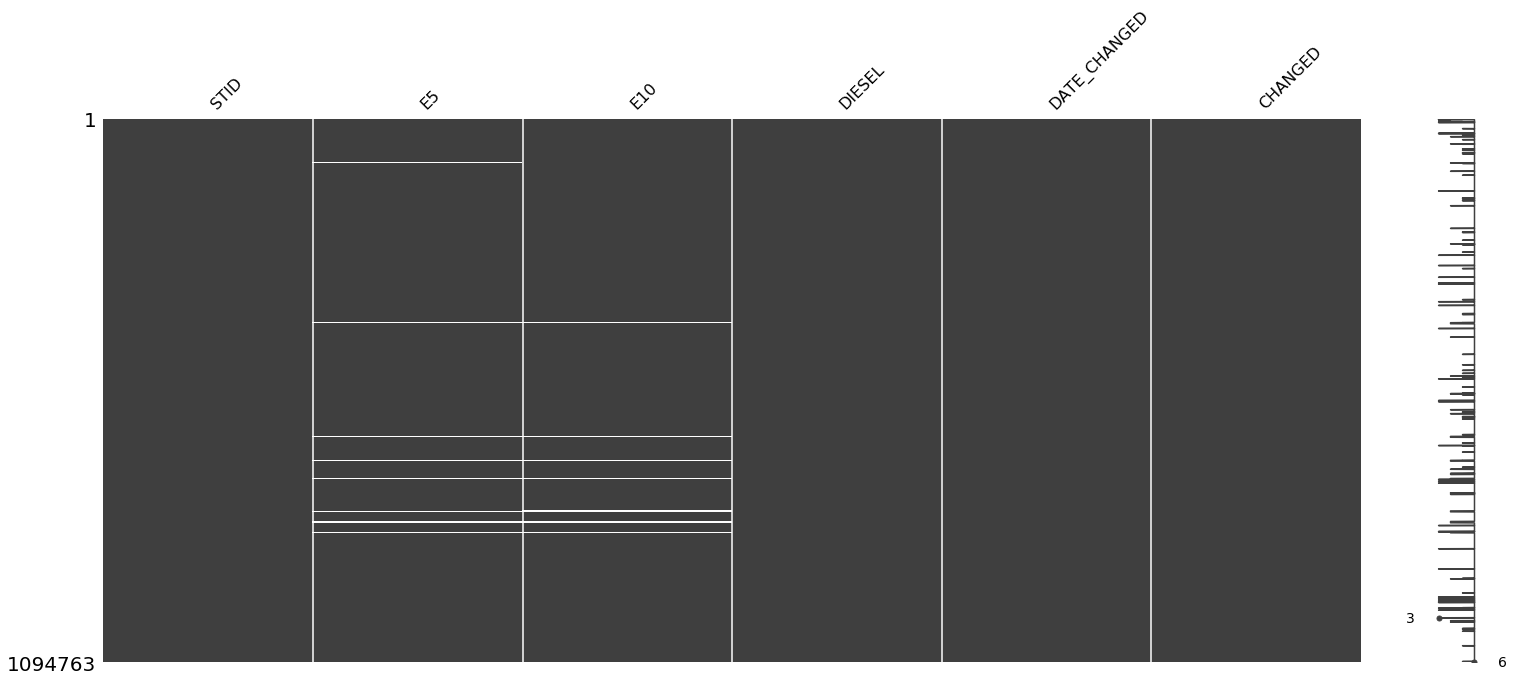

In [140]:
ms.matrix(price_data)

There are some missing values for E5 and E10 and only a few missing values for diesel.

In [141]:
price_data.isna().sum()

STID                0
E5              17111
E10             18998
DIESEL            185
DATE_CHANGED        0
CHANGED             0
dtype: int64

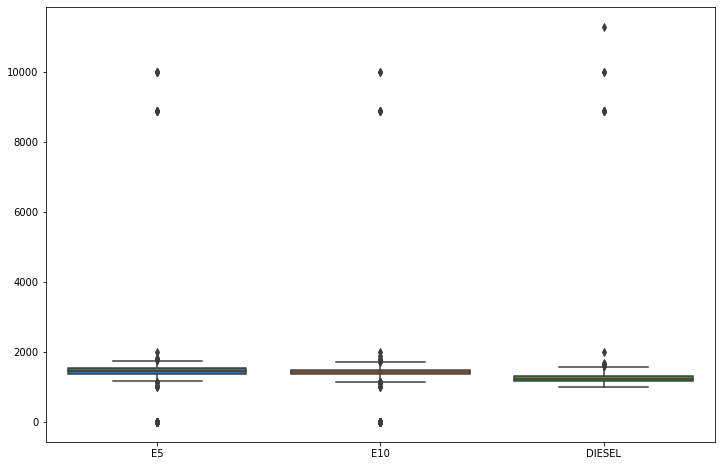

In [142]:
plt.figure(figsize=(12,8))
sns.boxplot(data=price_data[['E5', 'E10', 'DIESEL']])

There are some extreme outliers in the boxplot. These could be price errors or have been transferred incorrectly. A price around 10€ or 0€ doesn't make sense. So we can use the 3x interquartile range to set these values to NaN an keep the medium outliers

In [143]:
q75, q25 = np.percentile(price_data['DIESEL'].dropna(), [75, 25])
IQR = q75 - q25
minimum = q25 - (IQR * 3)
maximum = q75 + (IQR * 3)
price_data['DIESEL'] = price_data['DIESEL'].mask(price_data['DIESEL'] > maximum)
price_data['DIESEL'] = price_data['DIESEL'].mask(price_data['DIESEL'] < minimum)

In [144]:
q75, q25 = np.percentile(price_data['E5'].dropna(), [75, 25])
IQR = q75 - q25
minimum = q25 - (IQR * 3)
maximum = q75 + (IQR * 3)
price_data['E5'] = price_data['E5'].mask(price_data['E5'] > maximum)
price_data['E5'] = price_data['E5'].mask(price_data['E5'] < minimum)

In [145]:
q75, q25 = np.percentile(price_data['E10'].dropna(), [75, 25])
IQR = q75 - q25
minimum = q25 - (IQR * 3)
maximum = q75 + (IQR * 3)
price_data['E10'] = price_data['E10'].mask(price_data['E10'] > maximum)
price_data['E10'] = price_data['E10'].mask(price_data['E10'] < minimum)

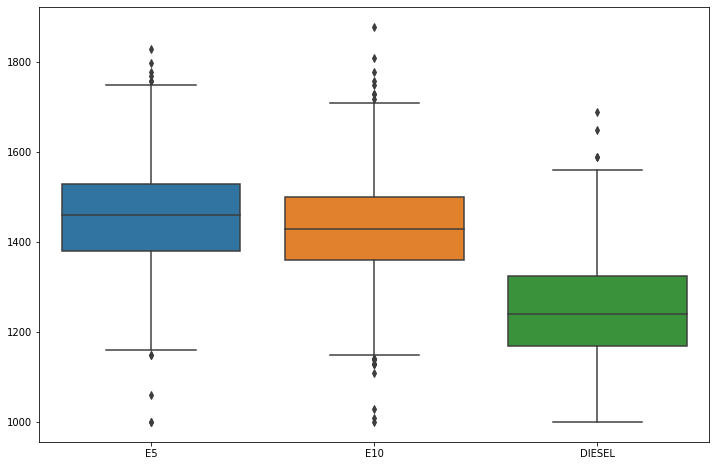

In [146]:
plt.figure(figsize=(12,8))
sns.boxplot(data=price_data[['E5', 'E10', 'DIESEL']])

Now our data set looks good and we can begin to analyze it. But first we have a look at the data set of the gas station.

Get the gas station information history:
- ID: unique gas station id
- VERSION: Version number, assigned by the operator
- VERSION_TIME: Information on the last change to the version number, assigned by the operator
- NAME: Name of gas station
- BRAND: Brand of gas station
- STREET: Street of gas station
- HOUSE_NUMBER: House number of gas station
- POST_CODE: Postcode of gas station
- PLACE: Name of the village
- PUBLIC_HOLDIDAY_IDENTIFIER: Abbreviation for state
- LAT: geographical latitude of the location
- LNG: geographical longitude of the location

In [147]:
station_data = pd.read_csv('example_sprit_cut_station.csv', sep=';')
station_data.head()

,ID,VERSION,VERSION_TIME,NAME,BRAND,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG
0,d37bee76-91b6-485a-b974-24f1b0d391fa,4,2015-01-09 10:26:15.000000,Aral Tankstelle,ARAL,An der Tagweide,2,76139,Karlsruhe,\N,49.020280,8.459429
1,51d4b652-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET MANNHEIM UNTERMUEHLAUSTRASSE 83,JET,UNTERMUEHLAUSTRASSE 83,\N,68169,MANNHEIM,\N,49.508962,8.467691
2,c7caf231-0e47-40db-92de-9349a2eb2bef,4,2014-09-26 13:24:57.000000,Aral Tankstelle,ARAL,Trippstadter Straße,69,67663,Kaiserslautern,\N,49.433754,7.757465
3,51d4b53b-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET KAISERSLAUTERN PARISER STR. 167,JET,PARISER STR. 167,\N,67655,KAISERSLAUTERN,\N,49.442200,7.748360
4,51d4b70f-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET GERMERSHEIM MUENCHENER STRASSE 12,JET,MUENCHENER STRASSE 12,\N,76726,GERMERSHEIM,\N,49.226800,8.374400


In [148]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 12 columns):
ID                           824 non-null object
VERSION                      824 non-null int64
VERSION_TIME                 824 non-null object
NAME                         824 non-null object
BRAND                        802 non-null object
STREET                       820 non-null object
HOUSE_NUMBER                 674 non-null object
POST_CODE                    820 non-null object
PLACE                        820 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    824 non-null object
LAT                          824 non-null float64
LNG                          824 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 77.3+ KB


The Version column is not very meaningful, format and use is left to the operator. So we delete the columns Version and Version date. Rename the column ID to STID so that the same name is used for the same data.

In [149]:
station_data.drop(['VERSION', 'VERSION_TIME'], axis=1, inplace=True)
station_data.rename(columns={'ID': 'STID'}, inplace=True)

First we remove duplicate rows and replace the unknown values \N with NaN

In [150]:
station_data.drop_duplicates(inplace=True)
station_data = station_data.replace('\\N', np.nan)
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 709
Data columns (total 10 columns):
STID                         412 non-null object
NAME                         412 non-null object
BRAND                        398 non-null object
STREET                       409 non-null object
HOUSE_NUMBER                 288 non-null object
POST_CODE                    409 non-null object
PLACE                        409 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    54 non-null object
LAT                          412 non-null float64
LNG                          412 non-null float64
dtypes: float64(2), object(8)
memory usage: 35.4+ KB


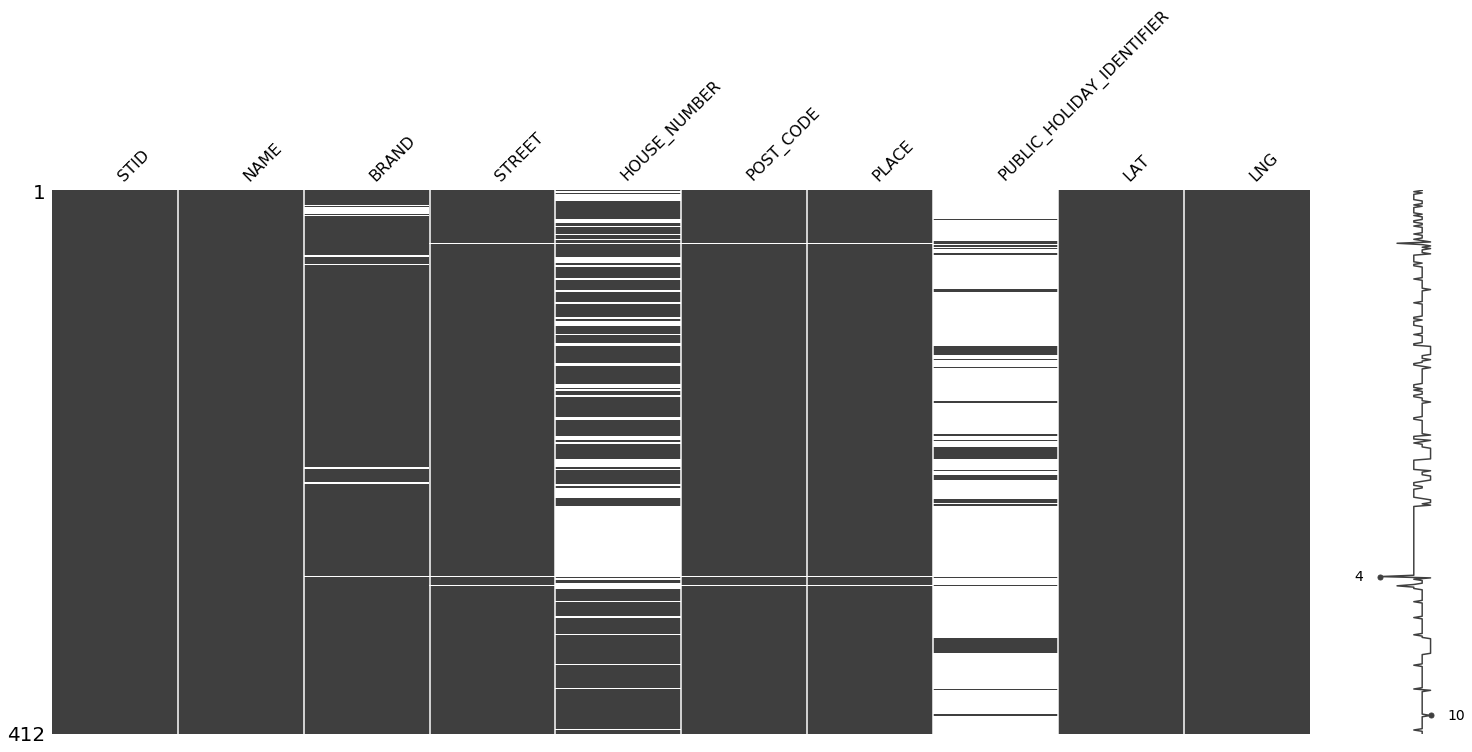

In [151]:
ms.matrix(station_data)

Many location informations and most public holiday identifier are missing. But the values of latitude and longitude are complete. So we can use these information to get the missing values

With geopy we can get location information from latitude and longitude

In [152]:
!pip install geopy
from geopy.geocoders import Nominatim

In [153]:
def get_address(row):
    try:
        # timeout: try maximal 10 times to get an answer from geolocator
        geolocator = Nominatim(user_agent='station_names', timeout=10) 
        location = geolocator.reverse(str(row['LAT']) + ', ' + str(row['LNG']), language='de')
        location = location.raw['address']
        
        if 'postcode' in location:
            row['POST_CODE'] = location['postcode']

        if 'state' in location:
            row['PUBLIC_HOLIDAY_IDENTIFIER'] = location['state']

        if 'road' in location:
            row['STREET'] = location['road']

        if 'house_number' in location:
            row['HOUSE_NUMBER'] = location['house_number']

        if 'village' in location:
            row['PLACE'] = location['village']
        elif 'city' in location:
            row['PLACE'] = location['city']
        elif 'town' in location:
            row['PLACE'] = location['town']

    # there is a limit of 2500 requests per day and sometimes we don't get an answer from the geolocator
    # in order to catch such cases we use this exception
    except Exception as ex:
        message = ("An exception of type {0} occurred ({1}) for " + row['ID']).format(type(ex).__name__, ex.args)
        print(message)        
        return row
              
    return row

In [154]:
station_data = station_data.apply(get_address, axis=1)

In [155]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 709
Data columns (total 10 columns):
STID                         412 non-null object
NAME                         412 non-null object
BRAND                        398 non-null object
STREET                       412 non-null object
HOUSE_NUMBER                 356 non-null object
POST_CODE                    412 non-null object
PLACE                        412 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    412 non-null object
LAT                          412 non-null float64
LNG                          412 non-null float64
dtypes: float64(2), object(8)
memory usage: 35.4+ KB


To all stations the street, postcode, town and state for the holiday identifier could be found. Only some brands and housenumbers are missing

## Question 1: How many different stations exist in the data set and what is the existing history in days?

In [157]:
unique_stids_price_data = price_data['STID'].unique()
unique_stids_station_data = station_data['STID'].unique()

In [30]:
!pip install geopandas

In [31]:
import geopandas as gpd

In [103]:
map_df = gpd.read_file('map/vg2500_bld.shp')

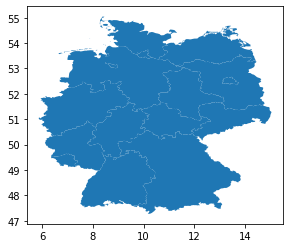

In [104]:
map_df.plot()

In [39]:
min(station_data['LAT'])

48.8007899

In [40]:
max(station_data['LAT'])

49.7993969

In [41]:
min(station_data['LNG'])

7.5053499000000015

In [42]:
max(station_data['LNG'])

8.4999409

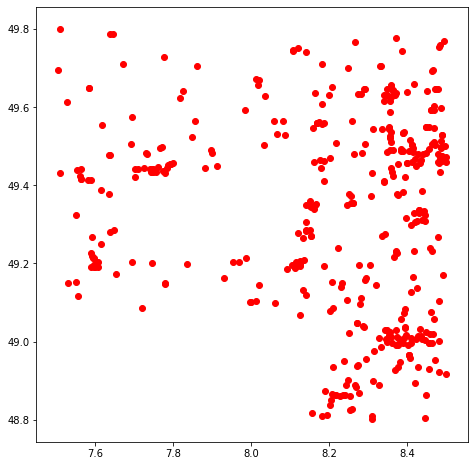

In [77]:
gdf.plot(color='red', figsize=(12,8))

In [80]:
gdf.head()

,STID,NAME,BRAND,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG,geometry
0,d37bee76-91b6-485a-b974-24f1b0d391fa,Aral Tankstelle,ARAL,An der Tagweide,2,76139,Karlsruhe,Baden-Württemberg,49.020280,8.459429,POINT (8.459429 49.0202799)
1,51d4b652-a095-1aa0-e100-80009459e03a,JET MANNHEIM UNTERMUEHLAUSTRASSE 83,JET,Untermühlaustraße,NaN,68169,Mannheim,Baden-Württemberg,49.508962,8.467691,POINT (8.467691 49.5089619)
2,c7caf231-0e47-40db-92de-9349a2eb2bef,Aral Tankstelle,ARAL,Trippstadter Straße,69,67663,Kaiserslautern,Rheinland-Pfalz,49.433754,7.757465,POINT (7.7574649 49.433754)
3,51d4b53b-a095-1aa0-e100-80009459e03a,JET KAISERSLAUTERN PARISER STR. 167,JET,Pariser Straße,NaN,67655,Kaiserslautern,Rheinland-Pfalz,49.442200,7.748360,POINT (7.748359900000001 49.4421999)
4,51d4b70f-a095-1aa0-e100-80009459e03a,JET GERMERSHEIM MUENCHENER STRASSE 12,JET,Münchener Straße,1,76726,Germersheim,Rheinland-Pfalz,49.226800,8.374400,POINT (8.3743999 49.2267999)


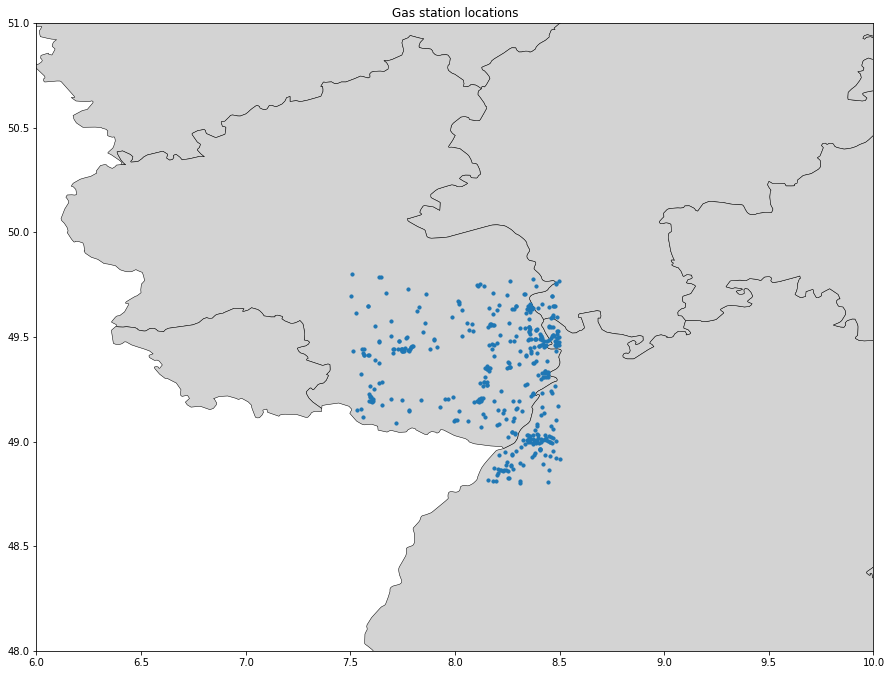

In [124]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = map_df.plot(color = 'lightgrey', linewidth = 0.5, edgecolor = 'black', figsize=(15,15))

ax.set_title("Gas station locations")
ax.set_xlim(6, 10)
ax.set_ylim(48, 51)

geo_df = gpd.GeoDataFrame(gdf, crs = {'init': 'epsg:4326'}, geometry = gdf['geometry'])
geo_df.plot(markersize = 10, ax = ax)

In [120]:
station_data.groupby(['BRAND']).count().sort_values(by=['STID'])

,STID,NAME,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG,geometry
BRAND,,,,,,,,,,
Raiffeisen Tankstelle,1,1,1,1,1,1,1,1,1,1
Mr. Wash Autoservice AG,1,1,1,1,1,1,1,1,1,1
Raiffeisen,1,1,1,1,1,1,1,1,1,1
nicht mehr aktiv,1,1,1,0,1,1,1,1,1,1
SB Markt,1,1,1,1,1,1,1,1,1,1
SB-Markttankstelle,1,1,1,1,1,1,1,1,1,1
Sefrin Heizöl & Kraftstoffe,1,1,1,1,1,1,1,1,1,1
Supermarkt Tankstelle,1,1,1,1,1,1,1,1,1,1
TAMOIL,1,1,1,1,1,1,1,1,1,1
